# Libraryes 
Download all the library needed to execution of the notebook

In [13]:
import pandas as pd
import numpy as np
from Bio.SVDSuperimposer import SVDSuperimposer
from Bio.PDB.PDBParser import PDBParser
import matplotlib.pyplot as plt
import os
from Bio.PDB import PDBList, calc_angle, calc_dihedral, PPBuilder, is_aa, PDBIO, NeighborSearch,Selection
from Bio.PDB.PDBParser import PDBParser
from Bio.SeqUtils import IUPACData
from Bio.PDB.PDBIO import Select
from Bio.SeqIO.PdbIO import PdbSeqresIterator
import numpy as np
import math
import matplotlib
import matplotlib.colors as mplcolors
import matplotlib.pyplot as plt
from RamachanDraw import phi_psi
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import copy
from Bio.SeqUtils import seq1
from IPython.display import display, HTML

# Protein download form PDB
This is the protein to analyze '2lea_A' download the assigned PDB structure and consider only standard (non-hetero) residues of the specified chain (<PDB ID>_<chain ID>). 

Calculate the contact map (question 1) and the conformational energy (questions 2 and 3) as described in the IUPRED paper. 

The M and P matrices are available from the iupred_data.py. The smoothed energy is the moving average of the raw energy over a window of 21 residues (±10 residues around the current position).

In [14]:
path = "."
id_protein, chain = ['2lea', 'A' ]
#id_protein, chain =['2k5d', 'A' ]
parser = PDBParser(QUIET=True)
# if the file does not exist, it will be downloaded
if os.path.exists(path + "/pdb/pdb{}.ent".format(id_protein.lower())) is True:
  path_pdb = path + "/pdb/pdb{}.ent".format(id_protein.lower())
else:
  pdbl = PDBList()
  path_pdb = pdbl.retrieve_pdb_file(id_protein, pdir=path + "/pdb", file_format="pdb")
structure = parser.get_structure(id_protein, path_pdb)
new_structure = structure.copy()

if os.path.exists(path +'/figures_mid_term2') is False:
  os.mkdir(path +'/figures_mid_term2') 

# Define main function to use

In [15]:
def get_distance_matrix(atoms, seq_sep=6):
  """
  Calculate a distance matrix considering only 
  CA atoms and a minimum sequence separation.  
  Return a Numpy array
  """
  distances = []
  for atom1 in atoms:
    row = []
    for atom2 in atoms:
      # Check sequence separation
      # if abs(atom1.id[1] - atom2.id[1]) >= seq_sep:
      if abs(atoms.index(atom1) - atoms.index(atom2)) >= seq_sep:
        row.append(atom1 - atom2)
      else:
        row.append(None) # For atoms not respecting sequence separation
    distances.append(row)
  return np.array(distances, dtype=float)

In [16]:
def get_contact_map(atoms,len_residues, threshold=3.5, seq_sep=2):

  # Calculate contacts
  ns = NeighborSearch(atoms)

  len_residues=len_residues+1
  # Init a empty matrix
  contact_map_nb = np.zeros((len_residues, len_residues))

  # "search_all" returns the list of atoms in contact based on a distance cutoff
  # level="R" returns pairs of residues instead of atoms
  for residues1, residues2 in ns.search_all(threshold, 'R'):
    if abs(residues1.id[1] - residues2.id[1]) >= seq_sep:
          contact_map_nb[residues1.id[1] , residues2.id[1]] = 1
          contact_map_nb[residues2.id[1], residues1.id[1]] = 1
  return contact_map_nb

#### Select the atoms

In [17]:
selected_atoms = [atom for residue in structure[0][chain] if residue.id[0] == " " for atom in residue]

# 1. Contacts calculated with Neighbours Search

(101, 101)


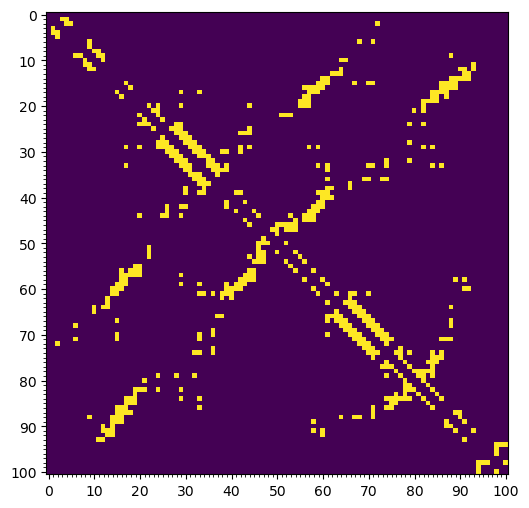

In [18]:

contact_map_nb = get_contact_map(selected_atoms, len([residue for residue in structure[0][chain] if residue.id[0]==" "]), threshold=3.5, seq_sep=2)
contact_map_nb = contact_map_nb[1:,1:]
print(contact_map_nb.shape)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(contact_map_nb)

# Set ticks
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(AutoMinorLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(AutoMinorLocator(10))

plt.savefig(path + '/figures_mid_term2/ca_contacts_nb{}.png'.format(id_protein), dpi=300, bbox_inches='tight')

1. Utilizzare la contact map 
2. i = 0 prendo il tipo ad esmpio 'A' 

# 2 . Exact Energy
> Calculate the exact energy of each residue based on the weighted contribution of its contacts
(as calculated above) and plot the raw and smoothed energy for each residue on the same figure.
Use the $M$ matrix to calculate the contact energy

 [Iupred_paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5734386/)

 Then, the energy of each residue is calculated by considering the number and types of the contacting amino acids and summing the appropriate elements of the statistical potential matrix.
$$E^{p}_i=∑^{20}_{j=1}M_{ij}c^{p}_j$$

where $E^{p}_i$ energy at position $p$ of type $i$, $M_{ij}$ is the interaction energy between amino acid types $i$ and $j$, and $c^{p}_j$ is the number of interactions of residue at position p with residues of type $j$ in the given conformation. Variations in these energies arise depending on the type and number of contacting residues, with hydrophobic residues buried inside the protein core generally exhibiting more favorable energies.

In [19]:
execfile("./iupred_data.py")
m_matrix = np.array(m_matrix)
p_matrix = np.array(p_matrix)

In [20]:
def get_sequences_of_residues(structure, aa_list):
    residues = [residue for residue in structure if residue.id[0] == " "]
    seq = "".join([seq1(residue.get_resname()) for residue in residues])
    print(f'sequence = {seq}')
    indices = [aa_list.index(aa) for aa in list(seq)]
    print(f'indices = {indices}')
    print(f'len(indices) = {len(indices)}')
    return indices

def c_j_calculator (contact_map, indices):
    c_j = np.zeros((len(indices), 20))
    for i in range(0,len(indices)):
        for j in range(0, len(indices)):
            if contact_map[i][j] == 1:
                c_j[i][indices[j]] += 1
    display(
        HTML(
            "<div style='height: 400px; overflow: auto; width: fit-content'>" +
            pd.DataFrame(c_j).to_html() +
            "</div>"
        )
    )
    print(f'shape of c_j = {c_j.shape}')
    return c_j

def Energy(m_matrix, c_j, indices):
    energy = np.zeros(len(indices))
    for i in range(0, len(indices)): #fill all the energy values
        type_of_aa = indices[i]
        for j in range(0,20):
            energy[i] += m_matrix[type_of_aa][j] * c_j[i][j]
    print(f'energy = {energy}')
    return energy


In [21]:
def iupred_M(structure, contact_map_nb, aa_list,m_matrix, window_size_smooth=10):
    '''
    Calculate residue IUPRED energy considering neighbouring residues (windows_size) and
    smoothing by window_size_smooth
    :param seq: a string of aminoacids
    :param sequence_separation: neighbours min distance
    :param window_size: neighbours max distance
    :param window_size_smooth: sliding average window size
    :return: row prediction, smoothed prediction
    '''
    pred_smooth = []
    indices = get_sequences_of_residues(structure[0][chain], aa_list)
    display(
        HTML(
            "<div style='height: 400px; overflow: auto; width: fit-content'>" +
            pd.DataFrame(contact_map_nb).to_html() +
            "</div>"
        )
    )
    c_j = c_j_calculator(contact_map_nb, indices)
    energy = Energy(m_matrix, c_j, indices)

    # Smooth the prediction (moving average)
    for i in range(len(energy)):
        frag = energy[max(0, i - window_size_smooth): min(i + window_size_smooth, len(energy))]
        pred_smooth.append(sum(frag) / len(frag))

    return energy, pred_smooth


# 3 Estimated Energy
> Calculate the estimated energy of each residue based on the weighted contribution of the frequency of neighboring amino acids in the sequence and plot the raw and smoothed energy for each residue on the same figure. Use the P matrix to calculate the estimated energy. Neighboring residues are those 2-100 residues apart from the current position.

To eliminate the need to know the precise arrangements of residues in the structure, an energy estimation method was developed that can be used to approximate the energies directly from the amino acid sequence. For this, a crude approximation was introduced assuming that energy of a given residue mostly depends on its own type and the types of the amino acids that surround it. The key component of the calculations is the energy estimation matrix, a 20 × 20 matrix that connects the elements of the amino acid composition vector to the energy of a given residue. The energy of a given residues can be obtained by multiplying the amino acid composition vector elements with the appropriate elements of this energy predictor matrix.
$$e^{p}_i=∑^{20}_{j=1}P_{ij}n^{p}_j$$
where $e^{p}_i$ is estimated energy at position $p$ of type $i$, $P_{ij}$ is the $ij$ element of the energy predictor matrix and $n^{p}_j$ is the $jth$ element of the amino acid composition vector. This amino acid composition vector is specific for position $p$, as it calculated by considering only the local sequential environment within $2–100$ residues in either direction. The choice of this range represents a trade‐off between the intention of covering most structured domains, but separating distinct domains in multidomain proteins.The matrix elements were optimized using least square fitting, to minimize the difference between energies estimated from the amino acid composition vector and the energies calculated from the known structure for each residue in the dataset of proteins. The correlation between the calculated and estimated energies was surprisingly strong at the level of complete proteins, confirming the validity of this approach.

In [22]:
def iupred_P(seq, sequence_separation=2, window_size=100, window_size_smooth=10):
    '''
    Calculate residue IUPRED energy considering neighbouring residues (windows_size) and
    smoothing by window_size_smooth
    :param seq: a string of aminoacids
    :param sequence_separation: neighbours min distance
    :param window_size: neighbours max distance
    :param window_size_smooth: sliding average window size
    :return: row prediction, smoothed prediction
    '''
    pred = []  # Calculated energy per sequence position
    pred_smooth = []

    indices = [aa_list.index(aa) for aa in list(seq)]  # Transform sequence into indexes as in the P matrix
    for i, aa_index in enumerate(indices):

        # Get the slice i-100/i+100 excluding adjacent positions (+/-1)
        start_before = max(0, i - window_size + 1)
        end_before = max(0, i - sequence_separation + 1)
        start_after = min(len(indices) - 1, i + sequence_separation)
        end_after = min(len(indices) - 1, i + window_size)
        indices_local = indices[start_before: end_before] + indices[start_after: end_after]

        # Count the different amino acids in the window
        row = np.full((20,), 0)
        for index in indices_local:
            row[index] += 1

        # calculate AA frequency
        row = row / len(indices_local)  

        # calculate energy
        row = row * p_matrix[aa_index, ]  

        aa_energy = np.sum(row)

        pred.append(aa_energy)

    # Smooth the prediction (moving average)
    for i in range(len(pred)):
        frag = pred[max(0, i - window_size_smooth): min(i + window_size_smooth, len(pred))]
        pred_smooth.append(sum(frag) / len(frag))

    return pred, pred_smooth

# Results point 2 and 3

sequence = MSYGRPPPDVEGMTSLKVDNLTYRTSPDTLRRVFEKYGRVGDVYIPRDRYTKESRGFAFVRFHDKRDAEDAMDAMDGAVLDGRELRVQMARYGRPPDSHHS
indices = [10, 15, 19, 5, 14, 12, 12, 12, 2, 17, 3, 5, 10, 16, 15, 9, 8, 17, 2, 11, 9, 16, 19, 14, 16, 15, 12, 2, 16, 9, 14, 14, 17, 4, 3, 8, 19, 5, 14, 17, 5, 2, 17, 19, 7, 12, 14, 2, 14, 19, 16, 8, 3, 15, 14, 5, 4, 0, 4, 17, 14, 4, 6, 2, 8, 14, 2, 0, 3, 2, 0, 10, 2, 0, 10, 2, 5, 0, 17, 9, 2, 5, 14, 3, 9, 14, 17, 13, 10, 0, 14, 19, 5, 14, 12, 12, 2, 15, 6, 6, 15]
len(indices) = 101


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


shape of c_j = (101, 20)
energy = [  0.     0.55   0.32   0.28   0.28  -0.12   0.68  -0.02   0.9   -1.23
   0.79   1.12  -0.68   0.14   0.85  -6.15   1.19  -7.51   1.33   0.73
  -4.18   0.75  -0.88   0.72   0.28   1.03   1.99  -0.27   1.89  -7.97
   0.04  -0.17  -3.28 -10.8    0.2    0.83  -3.89   1.36  -0.67  -2.98
   0.85   1.44  -3.9   -1.9   -3.69   0.89   1.04   0.68   0.45   0.43
   1.15   0.57   0.05   0.92  -0.44   0.48  -2.28  -1.74  -6.32  -6.83
   1.2   -5.05   0.3    0.22  -0.46  -1.58   1.57  -0.84   2.58   1.07
  -1.82  -2.67   1.66  -0.96  -5.07   1.11   1.68  -0.98   0.66  -2.62
   0.2    1.16   0.39   1.18  -6.11  -0.62  -4.65   1.03  -0.31  -1.3
   0.81  -2.84   1.06   0.66   1.04   0.25  -0.23   0.     0.48   0.25
   0.75]


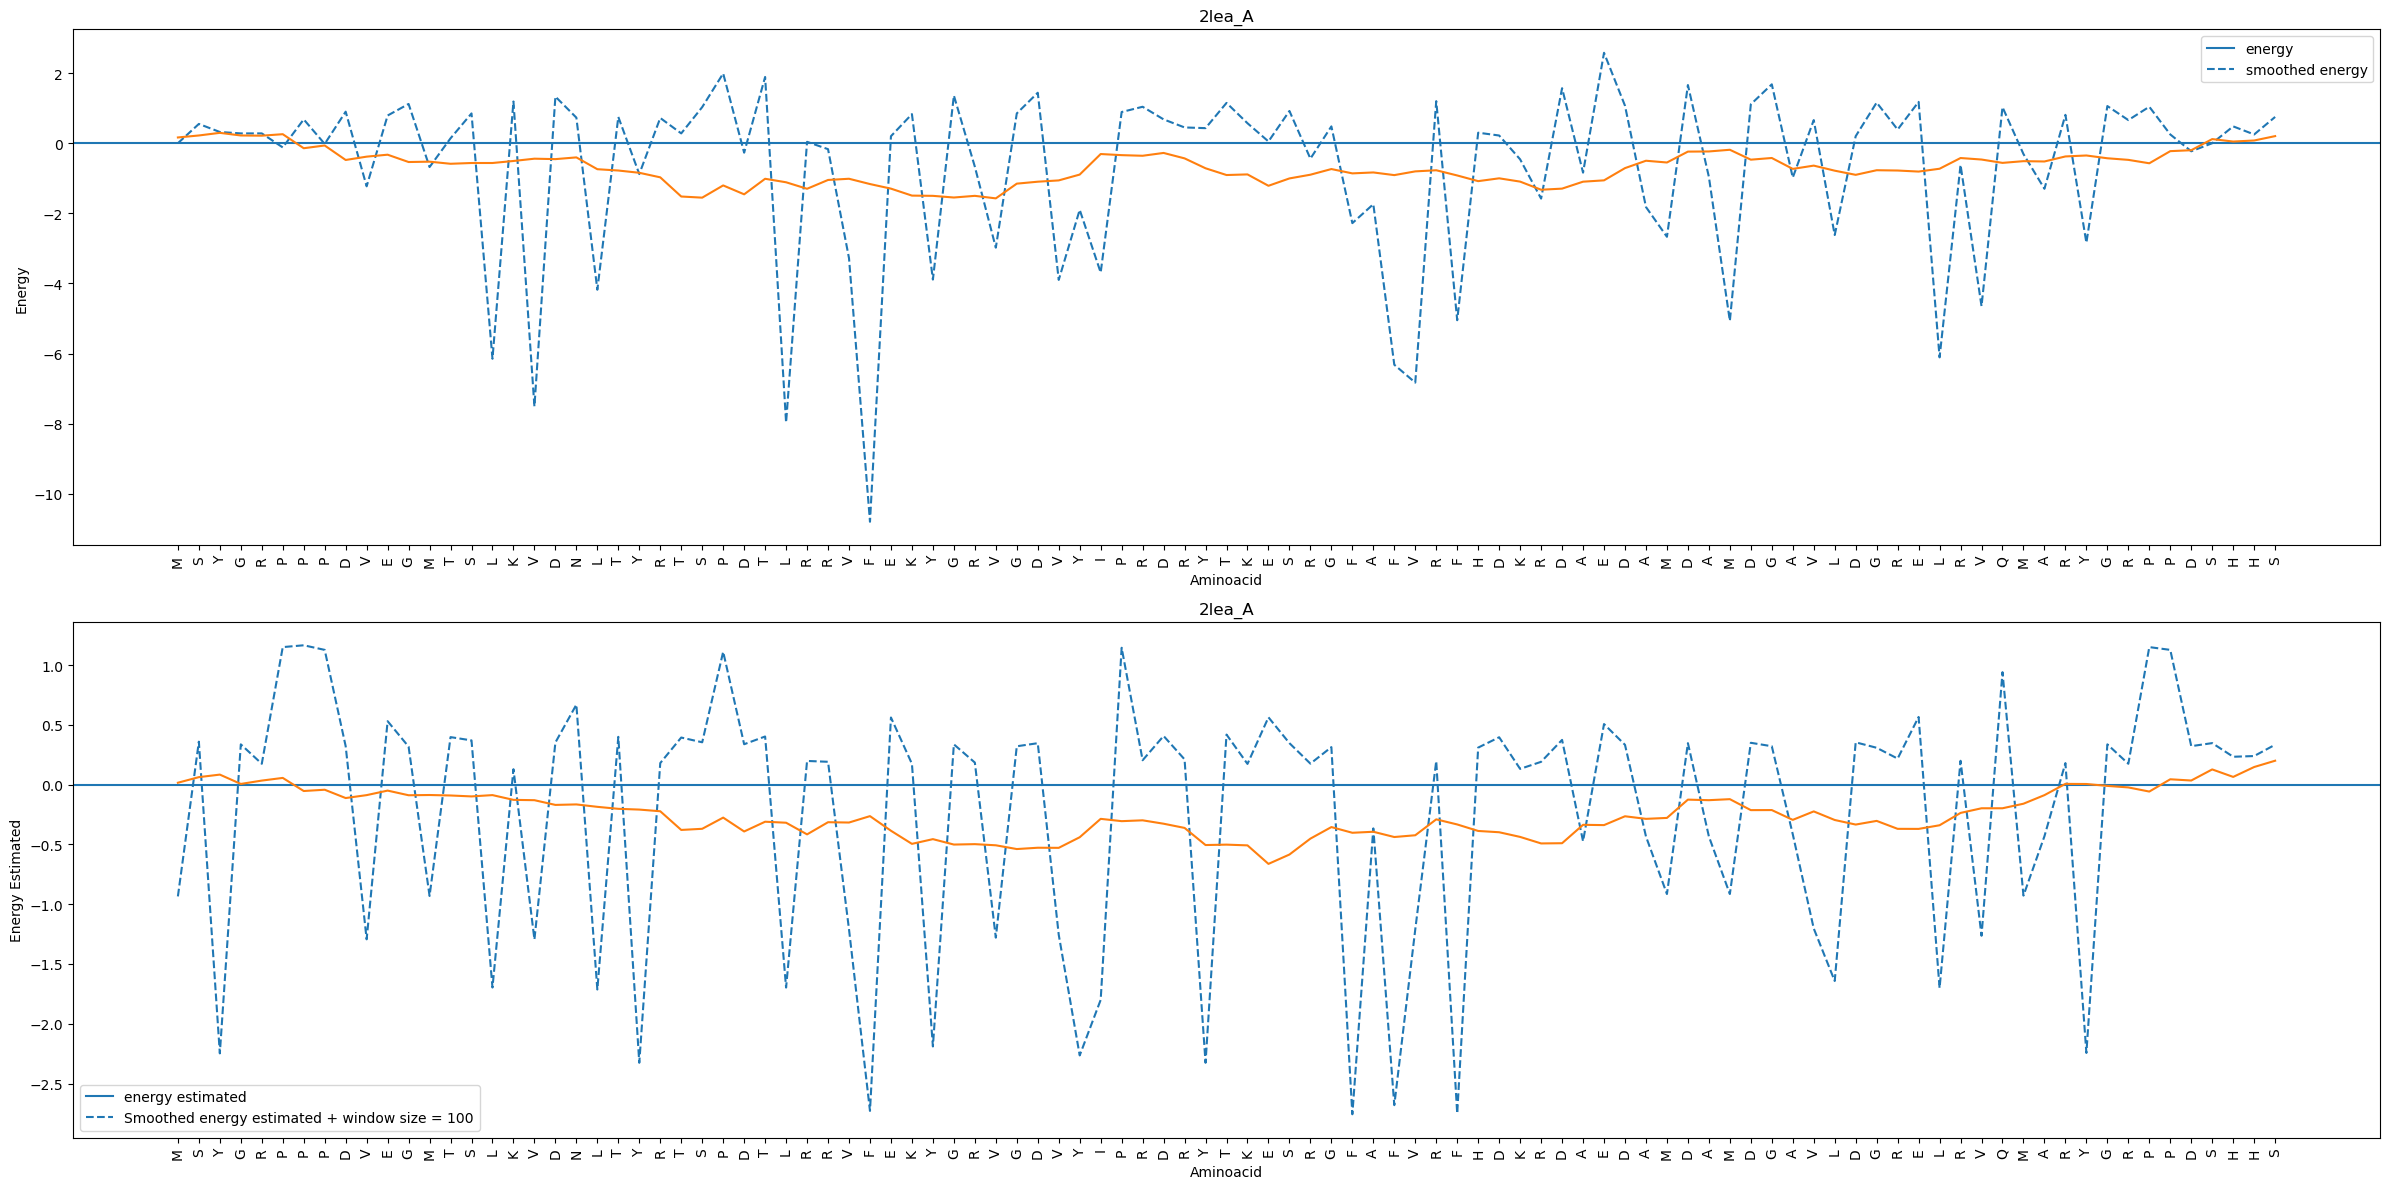

In [23]:
residues = [residue for residue in structure[0][chain] if residue.id[0] == " "]
seq = "".join([seq1(residue.get_resname()) for residue in residues])
pred, pred_smooth = iupred_M(structure, contact_map_nb, aa_list,m_matrix, window_size_smooth=10)
fig, ax = plt.subplots(2,figsize=(24, 12))
ax[0].set_title("{}_{}".format(id_protein, chain))
ax[0].axhline()
ax[0].plot(np.arange(len(seq)), pred, ls='--')
ax[0].plot(np.arange(len(seq)), pred_smooth, ls='-')
#write on axis x the aminoacid
ax[0].set_xticks(np.arange(len(seq)))
ax[0].set_xticklabels(list(seq))
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_ylabel("Energy")
ax[0].set_xlabel("Aminoacid")
ax[0].legend(["energy", "smoothed energy"])
#-------------------------------------------------------------------------------------------------------
window_size = 100
estpred, estpred_smooth = iupred_P(seq, sequence_separation = 2, window_size=window_size, window_size_smooth=10)
ax[1].set_title("{}_{}".format(id_protein, chain))
ax[1].axhline()
ax[1].plot(np.arange(len(seq)), estpred, ls='--')
ax[1].plot(np.arange(len(seq)), estpred_smooth, ls='-')
#write on axis x the aminoacid
ax[1].set_xticks(np.arange(len(seq)))
ax[1].set_xticklabels(list(seq))
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_ylabel("Energy Estimated")
ax[1].set_xlabel("Aminoacid")
ax[1].legend(["energy estimated", "Smoothed energy estimated + window size = 100"])
plt.tight_layout()  # Remove figure padding
plt.savefig(path + '/figures_mid_term2/iupred_{}_{}.png'.format(id_protein, chain), dpi=300, bbox_inches='tight')


In [24]:

names=["energy", "energy_smoothed", "est_energy", "est_energy_smooth"]
energies=[pred, pred_smooth, estpred, estpred_smooth]
counts_geq=[len([i for i in e if i >= 0]) for e in energies] 
counts_g=[len([i for i in e if i > 0]) for e in energies] 
fractions_geq=[c/len(seq) for c in counts_geq]
fractions_g=[c/len(seq) for c in counts_g]

df=pd.DataFrame({"count geq":counts_geq, "fraction geq":fractions_geq, "count g":counts_g, "fractions g":fractions_g}, index=names)
print(df)

                   count geq  fraction geq  count g  fractions g
energy                    60      0.594059       58     0.574257
energy_smoothed           10      0.099010       10     0.099010
est_energy                66      0.653465       66     0.653465
est_energy_smooth         14      0.138614       14     0.138614
